# Macroeconomic default modelling - a Machine Learning approach

### PART 3a

### Outline of the script(s)
- Creating the Analytic Base Table (ABT) + Exploratory Data Analysis _(0 ABT.ipynb)_


- Preprocessing the Dataset  _(1 Preprocessing.ipynb)_


__ Modelling changes in the default rate__   _(This Notebook)_

### First, let's load (and install where neccessary) the packages that we are using

In [108]:
### Load packages (and install the ones missing)
suppressMessages(if (!require("pacman")) install.packages("pacman", repos = "http://cran.us.r-project.org"))
#devtools::install_github("business-science/alphavantager")
#devtools::install_github("business-science/tidyquant")
#install.packages("tidyquant")
pacman::p_load("readxl","Hmisc","mice",
                                "VIM","car","Amelia", "IRdisplay",
                                "ggplot2", "dplyr", "caret", "broom",
                                "tibble","labeling", "digest", "tseries", 
                                "mombf", "robustbase","forecast", "caTools",
                                "mlbench", "party", "rpart", "e1071", "cluster",
                                "randomForest", "gbm", "xgboost", "h2o", "timetk",
                                "tidyquant", "nnet", "ggfortify", "DAAG", "neuralnet")#add more packages here if needed!

### Let's get all our transformed train and test dataset (For delta-Logit PD and delta-Logit AR)

In [109]:
#Find a more clever way to retrieve multiple .csv later :)
#Reminder: y_train_PD is supposed to be the delta-logit-PD (check 1_Processing script how that came about)
#Reminder2: y_train_AR is supposed to be the delta-logit-AR (check 1_Processing script how that came about)
document_name = "ABT_train_PD"
file_location=paste(getwd(),"/", document_name, sep= "")

ABT_train_PD <- read.csv(file_location, stringsAsFactors = FALSE)
ABT_train_PD <- as.data.frame(ABT_train_PD)
ABT_train_PD$Date = as.Date(as.character(ABT_train_PD$Date), "%Y-%m-%d")
####################################################################
document_name = "ABT_train_AR"
file_location=paste(getwd(),"/", document_name, sep= "")

ABT_train_AR <- read.csv(file_location, stringsAsFactors = FALSE)
ABT_train_AR <- as.data.frame(ABT_train_AR)
ABT_train_AR$Date = as.Date(as.character(ABT_train_AR$Date), "%Y-%m-%d")
####################################################################
document_name = "ABT_test_PD"
file_location=paste(getwd(),"/", document_name, sep= "")

ABT_test_PD <- read.csv(file_location, stringsAsFactors = FALSE)
ABT_test_PD <- as.data.frame(ABT_test_PD)
ABT_test_PD$Date = as.Date(as.character(ABT_test_PD$Date), "%Y-%m-%d")
####################################################################
document_name = "ABT_test_AR"
file_location=paste(getwd(),"/", document_name, sep= "")

ABT_test_AR <- read.csv(file_location, stringsAsFactors = FALSE)
ABT_test_AR <- as.data.frame(ABT_test_AR)
ABT_test_AR$Date = as.Date(as.character(ABT_test_AR$Date), "%Y-%m-%d")

## Modeling Part

### How to know if the model is best fit for your data?

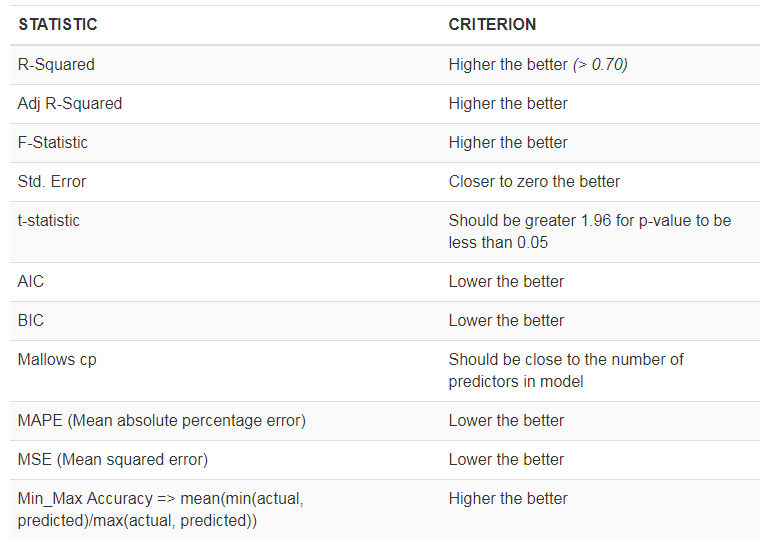

In [110]:
document_name = "measures.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location)  

## 1. Naive Model (This will be our benchmark)

- Always start with a Naive Approach to get the baseline error that you can measure up against future models

- Last observation carrying forward as prediction (Reason: if no indication on trend available, take the last obs, as it           contains most information that you can act upon

In [111]:
cat("Baseline RMSE train error for Delta-Logit-PD:", round(sqrt(mean(diff(ABT_train_PD$y_train_PD)^2)),4), "\n")
cat("Baseline MAE train error for Delta-Logit-PD: ", round((mean(abs(diff(ABT_train_PD$y_train_PD)))),4), "\n","\n")
cat("Baseline RMSE test error for Delta-Logit-PD:", round(sqrt(mean(diff(ABT_test_PD$y_test_PD)^2)),4), "\n")
cat("Baseline MAE test error for Delta-Logit-PD: ", round((mean(abs(diff(ABT_test_PD$y_test_PD)))),4), "\n","\n")

cat("And now for the Delta-Logit-AR:","\n","\n")

cat("Baseline RMSE train error for Delta-Logit-AR:", round(sqrt(mean(diff(ABT_train_AR$y_train_AR)^2)),4), "\n")
cat("Baseline MAE train error for Delta-Logit-AR: ", round((mean(abs(diff(ABT_train_AR$y_train_AR)))),4), "\n","\n")

cat("Baseline RMSE test error for Delta-Logit-AR:", round(sqrt(mean(diff(ABT_test_AR$y_test_AR)^2)),4), "\n")
cat("Baseline MAE test error for Delta-Logit-AR: ", round((mean(abs(diff(ABT_test_AR$y_test_AR)))),4), "\n","\n")

Baseline RMSE train error for Delta-Logit-PD: 0.0335 
Baseline MAE train error for Delta-Logit-PD:  0.0274 
 
Baseline RMSE test error for Delta-Logit-PD: 0.0094 
Baseline MAE test error for Delta-Logit-PD:  0.0078 
 
And now for the Delta-Logit-AR: 
 
Baseline RMSE train error for Delta-Logit-AR: 0.1933 
Baseline MAE train error for Delta-Logit-AR:  0.1245 
 
Baseline RMSE test error for Delta-Logit-AR: 0.4798 
Baseline MAE test error for Delta-Logit-AR:  0.2955 
 


### Conclusion: 

- As we can observe the errors are quite small for the Delta-Logit-PD Forecast


- This indicates that a autoregressive model should be suitable (at least it tells us that past values have some for of indication)



## 2. Linear Regression

The aim of linear regression is to model a continuous variable $Y$ as a mathematical function of one or more $X$ variable(s), so that we can use this regression model to predict the Y when only the X is known. This mathematical equation can be generalized as follows:

$$Y = \beta_1 + \beta_2 \cdot X +\epsilon$$

where, $\beta_1$ is the intercept and $\beta_2$ is the slope. Collectively, they are called regression coefficients. $\epsilon$ is the error term, the part of $Y$ the regression model is unable to explain.

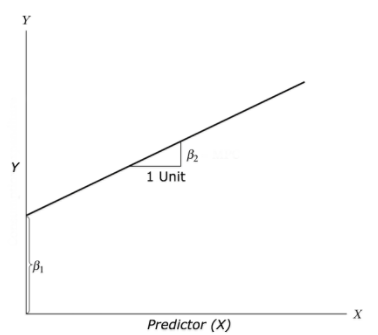

In [112]:
document_name = "LinearReg.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location)  

### The p Value: Checking for statistical significance

The summary statistics above tells us a number of things. One of them is the model p-Value (bottom last line) and the p-Value of individual predictor variables (extreme right column under ‘Coefficients’). The p-Values are very important because, We can consider a linear model to be statistically significant only when both these p-Values are less that the pre-determined statistical significance level, which is ideally 0.05. This is visually interpreted by the significance stars at the end of the row. The more the stars beside the variable’s p-Value, the more significant the variable.

Null and alternate hypothesis
When there is a p-value, there is a hull and alternative hypothesis associated with it. In Linear Regression, the Null Hypothesis is that the coefficients associated with the variables is equal to zero. The alternate hypothesis is that the coefficients are not equal to zero (i.e. there exists a relationship between the independent variable in question and the dependent variable).


### R-Squared and Adj R-Squared

What R-Squared tells us is the proportion of variation in the dependent (response) variable that has been explained by this model.

$$R^2 = 1- \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y}_i)^2}$$

i.e. the ratio between sum of _squared errors_ and _sum of squared total_

__Now thats about R-Squared. What about adjusted R-Squared?__ 

As you add more X variables to your model, the R-Squared value of the new bigger model will always be greater than that of the smaller subset. This is because, since all the variables in the original model is also present, their contribution to explain the dependent variable will be present in the super-set as well, therefore, whatever new variable we add can only add (if not significantly) to the variation that was already explained. It is here, the adjusted R-Squared value comes to help. Adj R-Squared penalizes total value for the number of terms (read predictors) in your model. Therefore when comparing nested models, it is a good practice to look at adj-R-squared value over R-squared.

$$R_{adj}^2 = 1- \bigg(\frac{(1-R^2)(n-1)}{n-q}\bigg)$$

We don’t necessarily discard a model based on a low R-Squared value. Its a better practice to look at the AIC and prediction accuracy on validation sample when deciding on the efficacy of a model.


where $n$ is the number of observations and $q$ is the number of coefficients in the model


__MinMaxAccuracy__

$$\text{MinMaxAccuracy} = \text{mean}\bigg(\frac{\min(actuals, predicted)}{\max(actuals, predicted)}\bigg)$$


__MeanAbsolutePercentageError (MAPE)__


$$\text{MAPE} = \text{mean}\bigg(\frac{\text{abs}(predicted-actuals)}{actuals}\bigg)$$


- Note: The MAPE can only be computed with respect to data that are guaranteed to be strictly positive, 
- so if this statistic is missing from your output where you would normally expect to see it,
- it’s possible that it has been suppressed due to negative data values.


__AIC and BIC__

The Akaike’s information criterion - AIC (Akaike, 1974) and the Bayesian information criterion - BIC (Schwarz, 1978) are measures of the goodness of fit of an estimated statistical model and can also be used for model selection. Both criteria depend on the maximized value of the likelihood function L for the estimated model.


__For model comparison, the model with the lowest AIC and BIC score is preferred.__

### We train our linear model on the train dataset

In [113]:
linearMod_PD <- lm(y_train_PD ~ ., data=ABT_train_PD[,-1]) #remove the Date column, as it's obviously not a predictor
linearMod_AR <- lm(y_train_AR ~ ., data=ABT_train_AR[,-1]) #remove the Date column, as it's obviously not a predictor

### Let's investigate on some diagnostic measures.

In [114]:
summary(linearMod_PD)
cat("####################And here below the summary for Delta-Logit-AR:#######################","\n")
summary(linearMod_AR)


Call:
lm(formula = y_train_PD ~ ., data = ABT_train_PD[, -1])

Residuals:
         Min           1Q       Median           3Q          Max 
-0.112352242 -0.038089286  0.000930997  0.031199984  0.129392290 

Coefficients:
                Estimate   Std. Error  t value               Pr(>|t|)    
(Intercept)  0.091823378  0.006761973 13.57938 < 0.000000000000000222 ***
PC1         -0.008077011  0.001317321 -6.13139    0.00000008754888757 ***
PC2          0.039052036  0.001752888 22.27869 < 0.000000000000000222 ***
PC3          0.032057562  0.002074999 15.44944 < 0.000000000000000222 ***
PC4          0.055827127  0.004008564 13.92697 < 0.000000000000000222 ***
PC5         -0.023840957  0.004256010 -5.60172    0.00000063959687068 ***
PC6         -0.044933622  0.004774567 -9.41104    0.00000000000033148 ***
PC7          0.007875706  0.005185987  1.51865               0.134378    
PC8          0.055175036  0.006074417  9.08318    0.00000000000112953 ***
PC9          0.012766697  0.006498999 

####################And here below the summary for Delta-Logit-AR:####################### 



Call:
lm(formula = y_train_AR ~ ., data = ABT_train_AR[, -1])

Residuals:
        Min          1Q      Median          3Q         Max 
-0.33067562 -0.02789119  0.00787503  0.03825185  0.46730849 

Coefficients:
                Estimate   Std. Error  t value     Pr(>|t|)    
(Intercept)  0.049150131  0.016540867  2.97144    0.0043345 ** 
PC1         -0.016943000  0.003222377 -5.25792 0.0000022736 ***
PC2          0.014735046  0.004287844  3.43647    0.0011066 ** 
PC3          0.003905670  0.005075779  0.76947    0.4447902    
PC4         -0.002266550  0.009805588 -0.23115    0.8180269    
PC5          0.003285269  0.010410881  0.31556    0.7534882    
PC6          0.014104554  0.011679355  1.20765    0.2321697    
PC7          0.008120104  0.012685754  0.64010    0.5246747    
PC8         -0.006645047  0.014858995 -0.44721    0.6564204    
PC9         -0.001944003  0.015897591 -0.12228    0.9031051    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standar

In [115]:
cat("The Akaike Information Criterion Score is:", AIC(linearMod_PD),"\n")
cat("The Bayesian Information Criterion Score is:", BIC(linearMod_PD),"\n")
cat("The Akaike Information Criterion Score is:", AIC(linearMod_AR),"\n")
cat("The Bayesian Information Criterion Score is:", BIC(linearMod_AR),"\n")

The Akaike Information Criterion Score is: -186.5008457 
The Bayesian Information Criterion Score is: -162.2492269 
The Akaike Information Criterion Score is: -66.63523954 
The Bayesian Information Criterion Score is: -42.38362073 


### For assessing the appropriatness of a linear model, let's also look at 

- Residual vs Fitted plot
- Normal Q-Q plot 

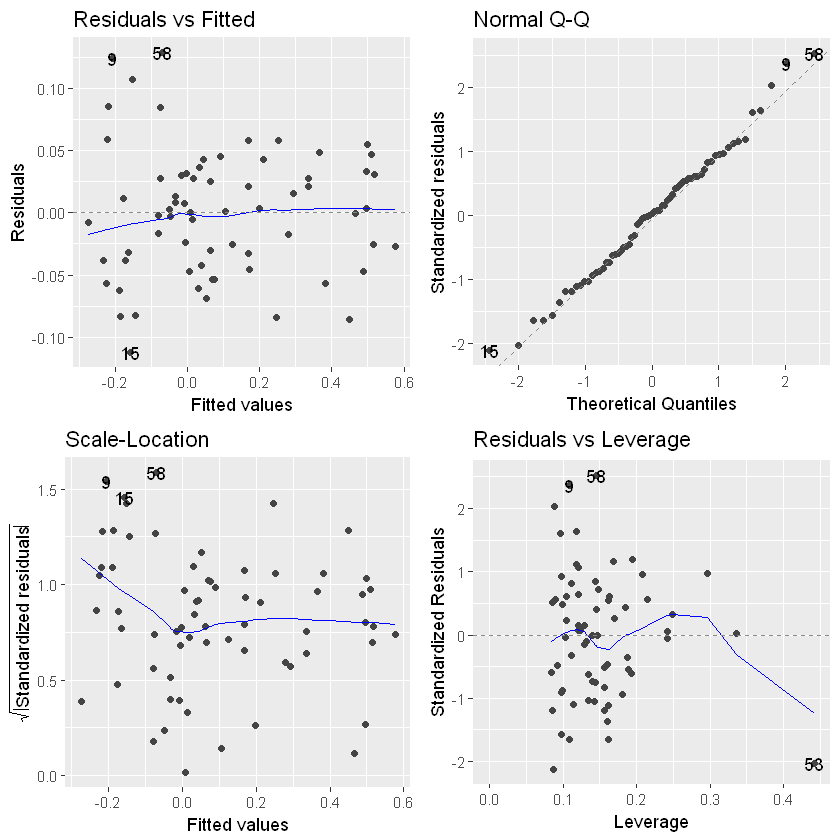

In [116]:
autoplot(linearMod_PD)

#################And now the results for the Delta_logit-AR###################### 


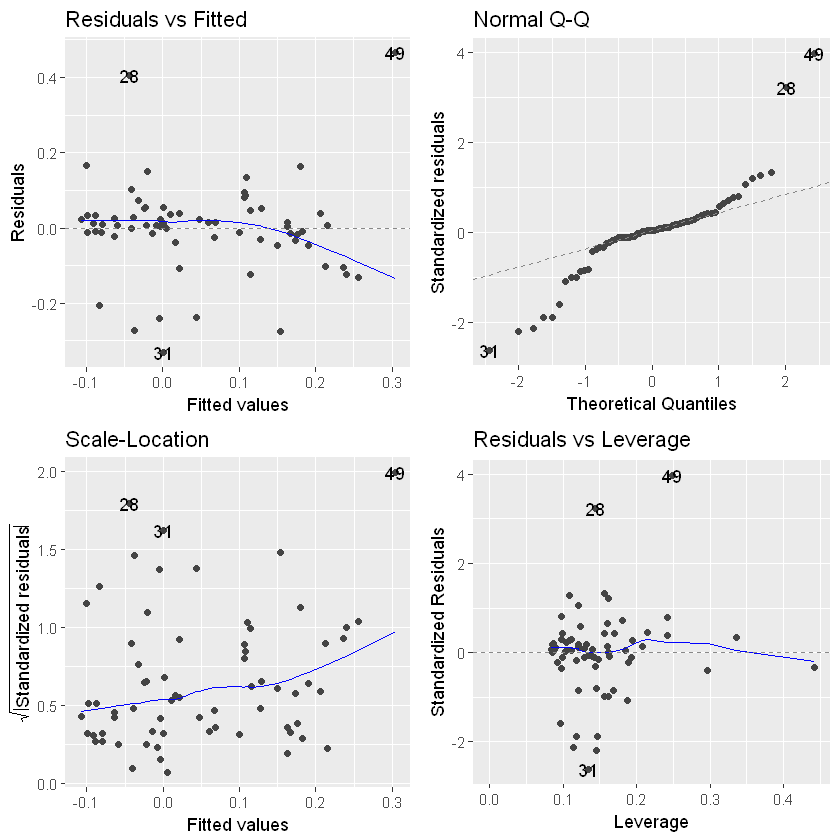

In [117]:
cat("#################And now the results for the Delta_logit-AR######################","\n")
autoplot(linearMod_AR)

### Let's look at the train error:

In [118]:
cat("RMSE train error for Delta-Logit-PD:", round(sqrt(mean((linearMod_PD$residuals)^2)),4), "\n")
cat("MAE train error for Delta-Logit-PD: ", round((mean(abs(linearMod_PD$residuals))),4), "\n","\n")

cat("RMSE train error for Delta-Logit-AR:", round(sqrt(mean((linearMod_AR$residuals)^2)),4), "\n")
cat("MAE train error for Delta-Logit-AR: ", round((mean(abs(linearMod_AR$residuals))),4), "\n","\n")

RMSE train error for Delta-Logit-PD: 0.0511 
MAE train error for Delta-Logit-PD:  0.0409 
 
RMSE train error for Delta-Logit-AR: 0.1249 
MAE train error for Delta-Logit-AR:  0.0776 
 


## Conclusion

- The p-value of the model is significant

- The Adj. R^2 seems quite large

- Most features are significant as well

__BUT__

- The linear model for Delta-Logit-PD performs worse in train as our baseline

- The linear model for Delta-Logit-AR is not suitable at all- however, it provides a better score than the benchmark

## Predicting Linear Models

In [119]:
test_predictions_PD = predict(linearMod_PD, ABT_test_PD%>%select(-Date, -y_test_PD))
test_predictions_AR = predict(linearMod_AR, ABT_test_AR%>%select(-Date, -y_test_AR))

### Calculate prediction accuracy and error rates : Let's look at the test error

In [120]:
cat("RMSE test error for Delta-Logit-PD:", round(sqrt(mean((test_predictions_PD - ABT_test_PD$y_test_PD)^2)),4), "\n")
cat("MAE test error for Delta-Logit-PD: ", round((mean(abs(test_predictions_PD - ABT_test_PD$y_test_PD))),4), "\n","\n")

cat("RMSE test error for Delta-Logit-AR:", round(sqrt(mean((test_predictions_AR - ABT_test_AR$y_test_AR)^2)),4), "\n")
cat("MAE test error for Delta-Logit-AR: ", round((mean(abs(test_predictions_AR - ABT_test_AR$y_test_AR))),4), "\n","\n")


RMSE test error for Delta-Logit-PD: 0.0757 
MAE test error for Delta-Logit-PD:  0.0658 
 
RMSE test error for Delta-Logit-AR: 0.3889 
MAE test error for Delta-Logit-AR:  0.279 
 


- A simple correlation between the actuals and predicted values can be used as a form of accuracy measure.


- A higher correlation accuracy implies that the actuals and predicted values have similar directional movement, i.e. when the actuals values increase the predicteds also increase and vice-versa.

## Conclusion about Linear Regression (tbd)

## 3. Neural Net

### Introduction

Neural network is an information-processing machine and can be viewed as analogous to human nervous system. Just like human nervous system, which is made up of interconnected neurons, a neural network is made up of interconnected information processing units. The information processing units do not work in a linear manner. In fact, neural network draws its strength from parallel processing of information, which allows it to deal with non-linearity. Neural network becomes handy to infer meaning and detect patterns from complex data sets.

Neural network is considered as one of the most useful technique in the world of data analytics. However, it is complex and is often regarded as a black box, i.e. users view the input and output of a neural network but remain clueless about the knowledge generating process. We hope that the article will help readers learn about the internal mechanism of a neural network and get hands-on experience to implement it in R.

### The Basics of Neural Network

A neural network is a model characterized by an activation function, which is used by interconnected information processing units to transform input into output. A neural network has always been compared to human nervous system. Information in passed through interconnected units analogous to information passage through neurons in humans. The first layer of the neural network receives the raw input, processes it and passes the processed information to the hidden layers. The hidden layer passes the information to the last layer, which produces the output. The advantage of neural network is that it is adaptive in nature. It learns from the information provided, i.e. trains itself from the data, which has a known outcome and optimizes its weights for a better prediction in situations with unknown outcome.

A perceptron, viz. single layer neural network, is the most basic form of a neural network.  A perceptron receives multidimensional input and processes it using a weighted summation and an activation function. It is trained using a labeled data and learning algorithm that optimize the weights in the summation processor. A major limitation of perceptron model is its inability to deal with non-linearity. A multilayered neural network overcomes this limitation and helps solve non-linear problems. The input layer connects with hidden layer, which in turn connects to the output layer. The connections are weighted and weights are optimized using a learning rule.

There are many learning rules that are used with neural network:

a) least mean square

b) gradient descent;

c) newton’s rule;

d) conjugate gradient etc.

The learning rules can be used in conjunction with backpropgation error method. The learning rule is used to calculate the error at the output unit. This error is backpropagated to all the units such that the error at each unit is proportional to the contribution of that unit towards total error at the output unit.  The errors at each unit are then used to optimize the weight at each connection. Figure 1 displays the structure of a simple neural network model for better understanding.

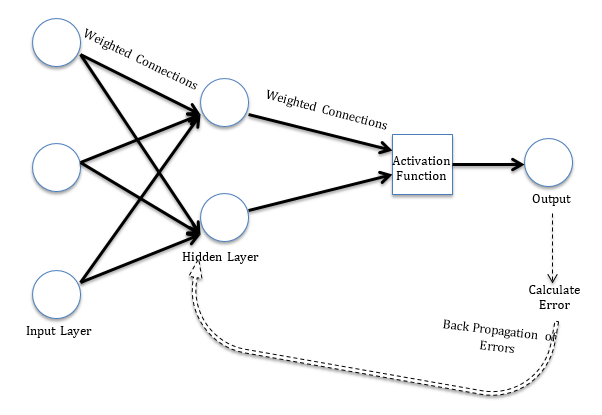

In [121]:
document_name = "nnet.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location)  

In [122]:
# fit neural network #develop flexible formula later!
set.seed(2)
NN_PD = neuralnet(y_train_PD ~ PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9, ABT_train_PD%>%select(-Date), hidden = 2 , linear.output = T )
NN_AR = neuralnet(y_train_AR ~ PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9, ABT_train_AR%>%select(-Date), hidden = 2,  linear.output = T )

# plot neural network (import picture from R-studio... figure out why doesn't work in jupyter notebook!)
plot(NN_PD)
plot(NN_AR)


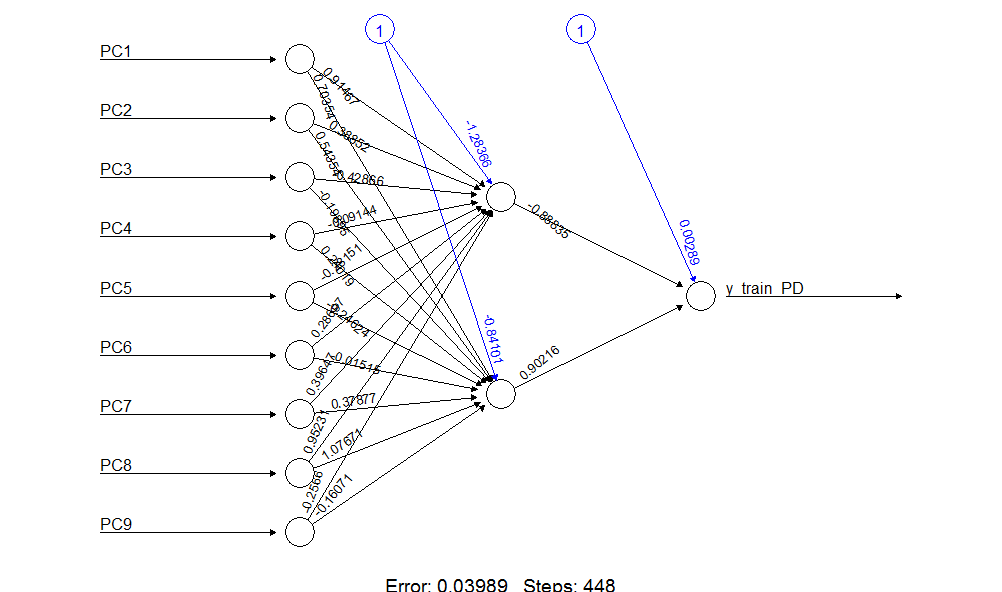

In [123]:
document_name = "NN_PD.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location)  

- The black lines show the connections between each layer and the weights on each connection while the blue lines show the bias term added in each step. The bias can be thought as the intercept of a linear model.


-  The net is essentially a black box so we cannot say that much about the fitting, the weights and the model. 


- Suffice to say that the training algorithm has converged and therefore the model is ready to be used.

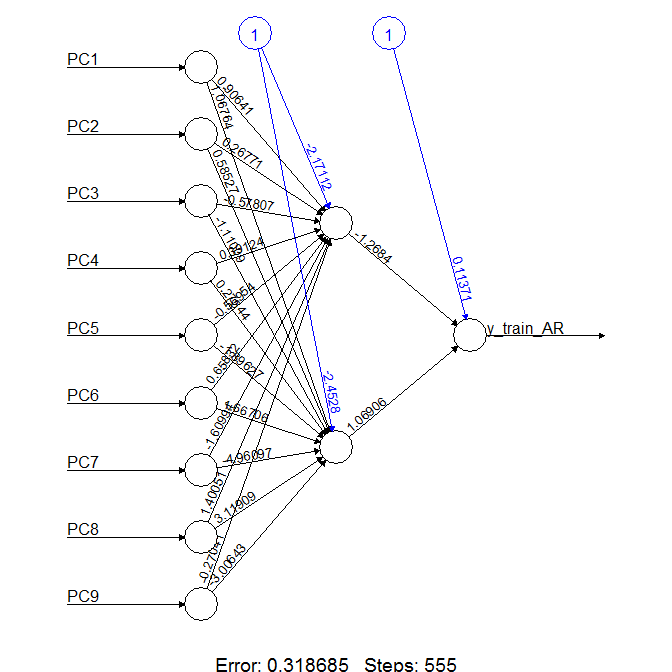

In [124]:
document_name = "NN_AR.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location)  

### Error analysis - Let's look at the train error:



In [125]:
NN_PD_pred = as.vector(NN_PD$net.result[[1]]) #retrieve the y_hat valeus
NN_AR_pred = as.vector(NN_AR$net.result[[1]])

cat("RMSE train error for Delta-Logit-PD:", round(sqrt(mean((NN_PD_pred-ABT_train_PD$y_train_PD)^2)),4), "\n")
cat("MAE train error for Delta-Logit-PD: ", round((mean(abs(NN_PD_pred-ABT_train_PD$y_train_PD))),4), "\n","\n")

cat("RMSE train error for Delta-Logit-AR:", round(sqrt(mean((NN_AR_pred-ABT_train_AR$y_train_AR)^2)),4), "\n")
cat("MAE train error for Delta-Logit-AR: ", round((mean(abs(NN_AR_pred-ABT_train_AR$y_train_AR))),4), "\n","\n")

RMSE train error for Delta-Logit-PD: 0.0345 
MAE train error for Delta-Logit-PD:  0.0274 
 
RMSE train error for Delta-Logit-AR: 0.1119 
MAE train error for Delta-Logit-AR:  0.0725 
 


## Prediction using neural network

In [126]:
NN_PD_test <- compute(NN_PD,ABT_test_PD%>%select(-Date,-y_test_PD))
NN_AR_test <- compute(NN_AR,ABT_test_AR%>%select(-Date,-y_test_AR))

### Let's look at the test error:


In [127]:
NN_PD_test_pred = as.vector(NN_PD_test$net.result) #retrieve the y_hat valeus
NN_AR_test_pred = as.vector(NN_AR_test$net.result)

cat("RMSE test error for Delta-Logit-PD:", round(sqrt(mean((NN_PD_test_pred-ABT_test_PD$y_test_PD)^2)),4), "\n")
cat("MAE test error for Delta-Logit-PD: ", round((mean(abs(NN_PD_test_pred-ABT_test_PD$y_test_PD))),4), "\n","\n")

cat("RMSE test error for Delta-Logit-AR:", round(sqrt(mean((NN_AR_test_pred-ABT_test_AR$y_test_AR)^2)),4), "\n")
cat("MAE test error for Delta-Logit-AR: ", round((mean(abs(NN_AR_test_pred-ABT_test_AR$y_test_AR))),4), "\n","\n")

RMSE test error for Delta-Logit-PD: 0.0541 
MAE test error for Delta-Logit-PD:  0.0444 
 
RMSE test error for Delta-Logit-AR: 0.4162 
MAE test error for Delta-Logit-AR:  0.2921 
 


### A first visual approach to the performance of the network and the linear model on the test set is plotted below

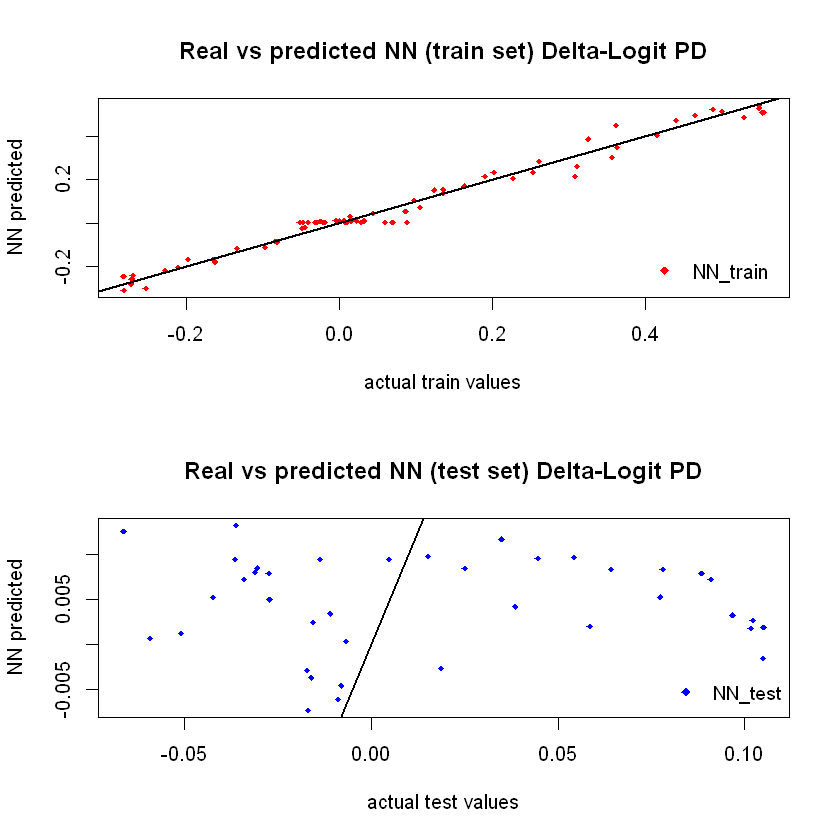

In [128]:
par(mfrow=c(2,1))
plot(ABT_train_PD$y_train_PD,NN_PD_pred,col='red',
     main='Real vs predicted NN (train set) Delta-Logit PD',pch=18,cex=0.7, ylab = "NN predicted", xlab = "actual train values")
abline(0,1,lwd=2)
legend('bottomright',legend='NN_train',pch=18,col='red', bty='n')
plot(ABT_test_PD$y_test_PD, NN_PD_test_pred,col='blue',
     main='Real vs predicted NN (test set) Delta-Logit PD',pch=18, cex=0.7, ylab = "NN predicted", xlab = "actual test values")
abline(0,1,lwd=2)
legend('bottomright',legend='NN_test',pch=18,col='blue', bty='n', cex=.95)


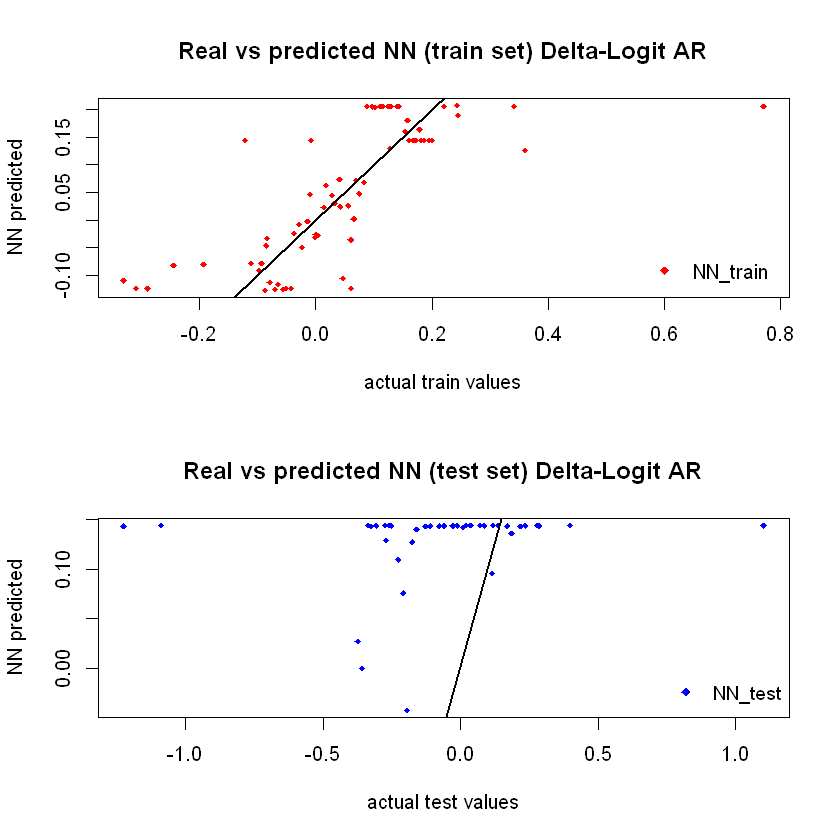

In [129]:
par(mfrow=c(2,1))
plot(ABT_train_AR$y_train_AR,NN_AR_pred,col='red',
     main='Real vs predicted NN (train set) Delta-Logit AR',pch=18,cex=0.7, ylab = "NN predicted", xlab = "actual train values")
abline(0,1,lwd=2)
legend('bottomright',legend='NN_train',pch=18,col='red', bty='n')
plot(ABT_test_AR$y_test_AR,NN_AR_test_pred,col='blue',
     main='Real vs predicted NN (test set) Delta-Logit AR',pch=18, cex=0.7, ylab = "NN predicted", xlab = "actual test values")
abline(0,1,lwd=2)
legend('bottomright',legend='NN_test',pch=18,col='blue', bty='n', cex=.95)

## the non-linear model for Delta-Logit-AR performs better than simply Linear Regression

In [130]:
mygrid <- expand.grid(.decay=c(0.5, 0.1), .size=c(1,2,3,4,5,6,7,8,9))#9features
nnetfit <- train(y_train_AR ~ ., data=ABT_train_AR[,-1], method="nnet", maxit=200, tuneGrid=mygrid, trace=F) 
print(nnetfit)

# in contrast

lmfit <- train(y_train_AR ~ ., data=ABT_train_AR[,-1], method="lm") 
print(lmfit)

Neural Network 

67 samples
 9 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 67, 67, 67, 67, 67, 67, ... 
Resampling results across tuning parameters:

  decay  size  RMSE          Rsquared      MAE          
  0.1    1     0.1502760670  0.2975009127  0.10420669619
  0.1    2     0.1484386750  0.2893067690  0.10287315283
  0.1    3     0.1472826165  0.2899906728  0.10151445190
  0.1    4     0.1462416662  0.2930703635  0.10047461087
  0.1    5     0.1452379736  0.2986082215  0.09936393948
  0.1    6     0.1444220741  0.3031443486  0.09854671435
  0.1    7     0.1438096622  0.3074205280  0.09788322264
  0.1    8     0.1432838718  0.3111209466  0.09732003799
  0.1    9     0.1426325800  0.3154283046  0.09669090421
  0.5    1     0.1745207195  0.3411645230  0.13373212346
  0.5    2     0.1685845404  0.3434214571  0.12786938729
  0.5    3     0.1648154703  0.3442762477  0.12368117712
  0.5    4     0.1620111697  0.3450665295  0.12033264538
  0.5 

## Let's try out more heavy machinery

## XGBoost

In [131]:
TrainControl <- trainControl( method = "repeatedcv", number = 5, repeats = 4)

model_PD<- train(y_train_PD ~ ., data=ABT_train_PD[,-1], method = "xgbLinear", trControl = TrainControl,verbose = FALSE)

model_AR<- train(y_train_AR ~ ., data=ABT_train_AR[,-1], method = "xgbLinear", trControl = TrainControl,verbose = FALSE)

In [132]:
predicted_train_PD = predict(model_PD)
predicted_train_AR = predict(model_AR)

cat("RMSE_train error for Delta-Logit PD:", round(sqrt(mean((predicted_train_PD - ABT_train_PD$y_train_PD)^2)),4), "\n")
cat("MAE_train error for Delta-Logit PD:", round((mean(abs(predicted_train_PD - ABT_train_PD$y_train_PD))),4), "\n","\n")


cat("RMSE_train error for Delta-Logit AR:", round(sqrt(mean((predicted_train_AR - ABT_train_AR$y_train_AR)^2)),4), "\n")
cat("MAE_train error for Delta-Logit AR: ", round((mean(abs(predicted_train_AR - ABT_train_AR$y_train_AR))),4), "\n","\n")

predicted_test_PD <- predict(model_PD, ABT_test_PD%>%select(-Date,-y_test_PD))
cat("RMSE_test error for Delta-Logit PD: ", round(sqrt(mean((predicted_test_PD - ABT_test_PD$y_test_PD)^2)),4), "\n")
cat("MAE_test error for Delta-Logit PD: ", round((mean(abs(predicted_test_PD - ABT_test_PD$y_test_PD))),4), "\n", "\n")


predicted_test_AR <- predict(model_AR, ABT_test_AR%>%select(-Date,-y_test_AR))
cat("RMSE_test error for Delta-Logit AR: ", round(sqrt(mean((predicted_test_AR - ABT_test_AR$y_test_AR)^2)),4), "\n")
cat("MAE_test error for Delta-Logit AR:  ", round((mean(abs(predicted_test_AR - ABT_test_AR$y_test_AR))),4), "\n", "\n")


RMSE_train error for Delta-Logit PD: 0.0108 
MAE_train error for Delta-Logit PD: 0.007 
 
RMSE_train error for Delta-Logit AR: 0.0147 
MAE_train error for Delta-Logit AR:  0.009 
 
RMSE_test error for Delta-Logit PD:  0.067 
MAE_test error for Delta-Logit PD:  0.0598 
 
RMSE_test error for Delta-Logit AR:  0.3666 
MAE_test error for Delta-Logit AR:   0.2472 
 


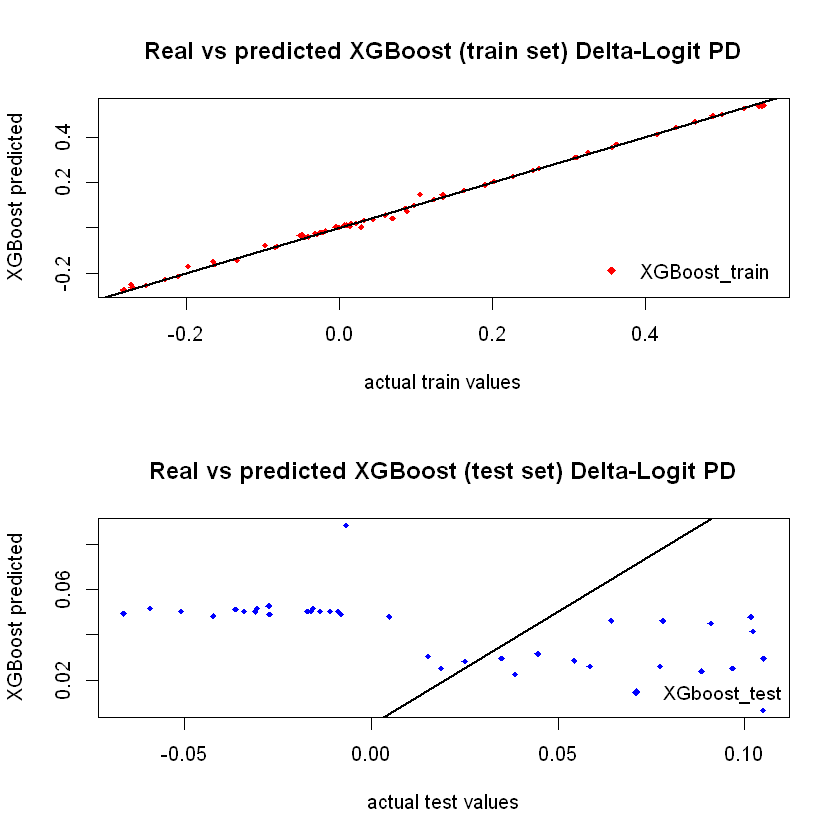

In [133]:
par(mfrow=c(2,1))
plot(ABT_train_PD$y_train_PD,predicted_train_PD,col='red',
     main='Real vs predicted XGBoost (train set) Delta-Logit PD',pch=18,cex=0.7, ylab = "XGBoost predicted", xlab = "actual train values")
abline(0,1,lwd=2)
legend('bottomright',legend='XGBoost_train',pch=18,col='red', bty='n')
plot(ABT_test_PD$y_test_PD, predicted_test_PD,col='blue',
     main='Real vs predicted XGBoost (test set) Delta-Logit PD',pch=18, cex=0.7, ylab = "XGBoost predicted", xlab = "actual test values")
abline(0,1,lwd=2)
legend('bottomright',legend='XGboost_test',pch=18,col='blue', bty='n', cex=.95)


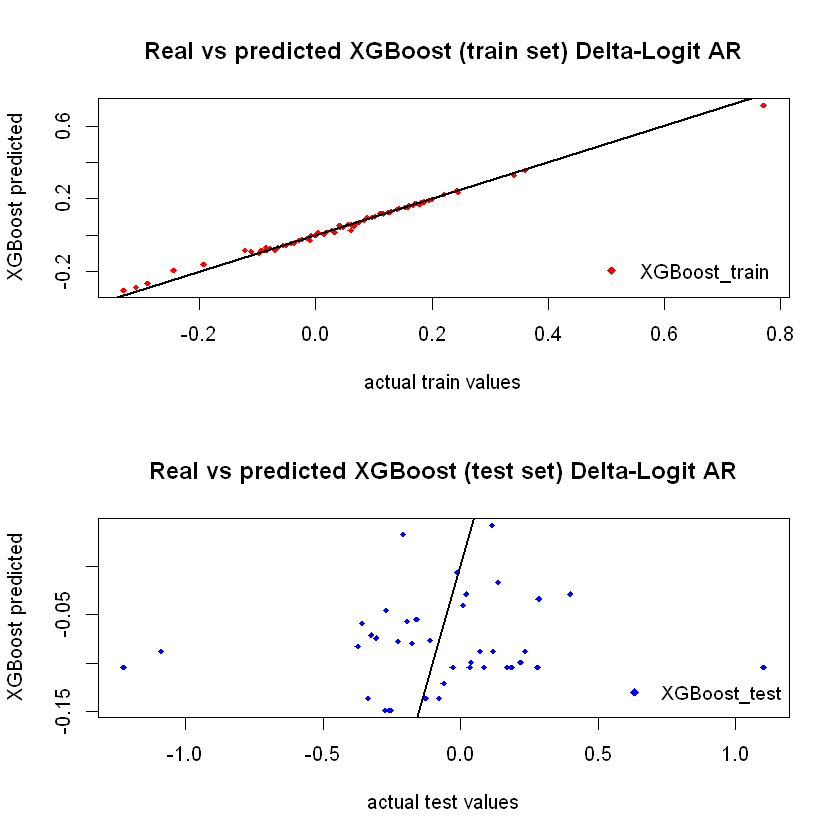

In [134]:
par(mfrow=c(2,1))
plot(ABT_train_AR$y_train_AR,predicted_train_AR,col='red',
     main='Real vs predicted XGBoost (train set) Delta-Logit AR',pch=18,cex=0.7, ylab = "XGBoost predicted", xlab = "actual train values")
abline(0,1,lwd=2)
legend('bottomright',legend='XGBoost_train',pch=18,col='red', bty='n')
plot(ABT_test_AR$y_test_AR,predicted_test_AR,col='blue',
     main='Real vs predicted XGBoost (test set) Delta-Logit AR',pch=18, cex=0.7, ylab = "XGBoost predicted", xlab = "actual test values")
abline(0,1,lwd=2)
legend('bottomright',legend='XGBoost_test',pch=18,col='blue', bty='n', cex=.95)

In [107]:
#End

# H2O

## The h2o package is a product offered by H2O.ai that contains a number of cutting edge machine learning algorithms, performance metrics, and auxiliary functions to make machine learning both powerful and easy. One of the main benefits of H2O is that it can be deployed on a cluster (this will not be discussed today). From the R perspective, there are four main uses:

1. Data Manipulation: Merging, grouping, pivoting, imputing, splitting into training/test/validation sets, etc.

2. Machine Learning Algorithms: Very sophisiticated algorithms in both supervised and unsupervised categories. Supervised include deep learning (neural networks), random forest, generalized linear model, gradient boosting machine, naive bayes, stacked ensembles, and xgboost. Unsupervised include generalized low rank models, k-means and PCA. There’s also Word2vec for text analysis. The latest stable release also has AutoML: automatic machine learning, which is really cool as we’ll see in this post!

3. Auxiliary ML Functionality Performance analysis and grid hyperparameter search

4. Production, Map/Reduce and Cloud: Capabilities for productionizing into Java environments, cluster deployment with Hadoop / Spark (Sparkling Water), deploying in cloud environments (Azure, AWS, Databricks, etc)

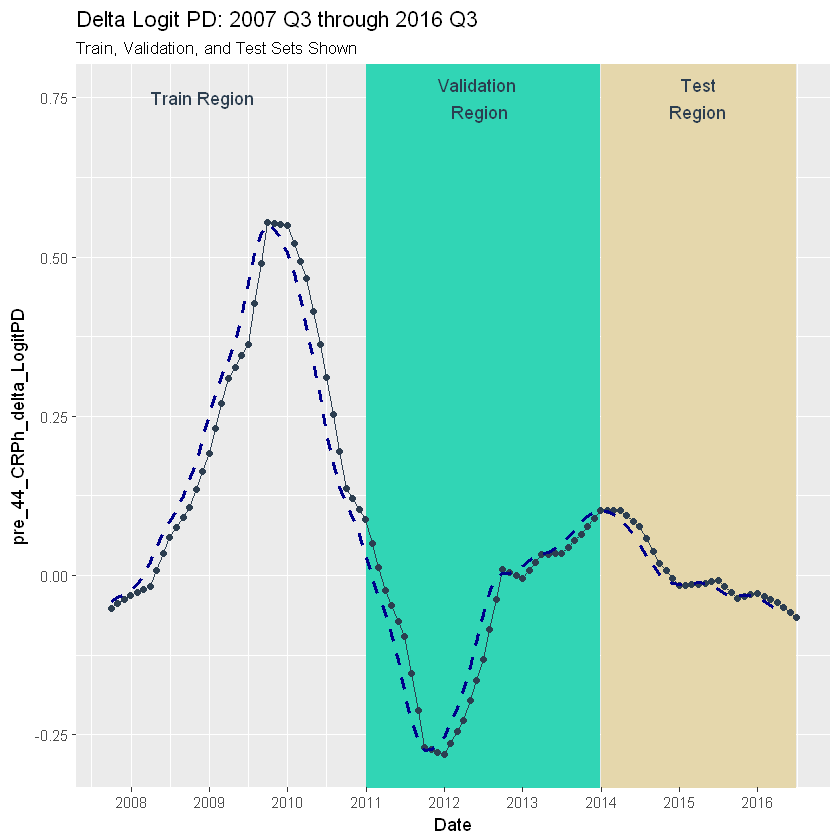

In [22]:
ABT %>%
    ggplot(aes(Date, pre_44_CRPh_delta_LogitPD))+
# Train Region
    annotate("text", x = ymd("2008-12-01"), y = 0.75,
             color = palette_light()[[1]], label = "Train Region")+
# Validation Region
    geom_rect(xmin = as.numeric(ymd("2011-01-01")), 
              xmax = as.numeric(ymd("2013-12-31")),
              ymin = -1, ymax = Inf, alpha = 0.02,
              fill = palette_light()[[3]])+
    annotate("text", x = ymd("2012-06-01"), y = 0.75,
             color = palette_light()[[1]], label = "Validation\n Region")+
# Test Region
    geom_rect(xmin = as.numeric(ymd("2014-01-01")), 
              xmax = as.numeric(ymd("2016-06-30")),
              ymin = -1, ymax = Inf, alpha = 0.02,
              fill = palette_light()[[4]]) +
    annotate("text", x = ymd("2015-03-31"), y = 0.75,
     color = palette_light()[[1]], label = "Test\nRegion") +
# Data
    geom_line(col = palette_light()[1]) +
    geom_point(col = palette_light()[1]) +
    geom_ma(ma_fun = SMA, n = 4, size = 1) +
# Aesthetics
    #theme_tq() +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Delta Logit PD: 2007 Q3 through 2016 Q3",
         subtitle = "Train, Validation, and Test Sets Shown") 

In [23]:
# Split into training, validation and test sets
train_tbl <- ABT %>% filter(Date < "2011-01-01") %>% select(-contains("Date"))
valid_tbl <- ABT %>% filter(Date > "2010-01-01" & Date < "2014-01-01")%>% select(-contains("Date"))
test_tbl  <- ABT %>% filter(Date > "2014-01-01")%>% select(-contains("Date"))

In [24]:
test_tbl$pre_44_CRPh_delta_LogitPD

[1] -0.066273124 -0.058267007 -0.050260889 -0.042254772 -0.037314594
 [6] -0.032374417 -0.027434240 -0.030398276 -0.033362312 -0.036326348
[11] -0.026873253 -0.017420159 -0.007967064 -0.009886063 -0.011805062
[16] -0.013724061 -0.014308577 -0.014893092 -0.015477607 -0.004045917
[21]  0.007385774  0.018817464  0.038321705  0.057825945  0.077330186
[26]  0.085605984  0.093881782  0.102157580  0.101988065  0.101818550

In [25]:
h2o.shutdown(prompt = TRUE)

ERROR: Error in h2o.shutdown(prompt = TRUE): There is no H2O instance running.


In [26]:
h2o.init()


H2O is not running yet, starting it now...


Warning message in .h2o.startJar(ip = ip, port = port, nthreads = nthreads, max_memory = max_mem_size, :
"You have a 32-bit version of Java. H2O works best with 64-bit Java.
Please download the latest Java SE JDK 7 from the following URL:
http://www.oracle.com/technetwork/java/javase/downloads/jdk7-downloads-1880260.html"


Note:  In case of errors look at the following log files:
    C:\Users\uhoenig\AppData\Local\Temp\Rtmp4OB2GW/h2o_uhoenig_started_from_r.out
    C:\Users\uhoenig\AppData\Local\Temp\Rtmp4OB2GW/h2o_uhoenig_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         10 seconds 288 milliseconds 
    H2O cluster version:        3.16.0.2 
    H2O cluster version age:    5 months and 13 days !!! 
    H2O cluster name:           H2O_started_from_R_uhoenig_sqc987 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.96 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.

Warning message in h2o.clusterInfo():
"
Your H2O cluster version is too old (5 months and 13 days)!
Please download and install the latest version from http://h2o.ai/download/"

In [27]:
# Convert to H2OFrame objects
train_h2o <- as.h2o(train_tbl)
valid_h2o <- as.h2o(valid_tbl)
test_h2o  <- as.h2o(test_tbl)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [28]:
# Set names for h2o
y <- "pre_44_CRPh_delta_LogitPD"
x <- setdiff(names(train_h2o), y)

In [29]:
#train_h2o$pre_44_CRPh_delta_LogitPD
train_h2o
test_h2o
valid_h2o


  pre_44_CRPh_delta_LogitPD      PC1      PC2       PC3        PC4      PC5
1                0.08743362 5.712282 1.064522 -8.870529  0.6041674 6.804667
2                0.10384492 5.255390 2.863493 -6.434222 -0.4913040 7.034012
3                0.12025622 4.650849 2.838058 -6.211015  1.7730441 6.142481
4                0.13666752 3.947577 4.564823 -5.360057  2.9375921 5.324156
5                0.19502610 3.382674 6.878932 -2.643235  1.7881073 6.080880
6                0.25338467 6.291858 6.617925 -2.536965  4.8539609 4.765334
         PC6         PC7       PC8      PC10       PC12       PC13       PC15
1 -1.4923503 -3.70776798 0.8873129 1.3993682 -1.6546973 -0.5037601 -0.7715817
2  0.2667675  0.02403576 1.9303860 0.3940455 -1.7083937  0.6476555  1.1456441
3 -1.0405225 -0.99183827 2.1900001 0.9926027 -2.2069675  0.8431528  0.5629607
4 -2.6220605 -1.56359275 2.5352271 1.8683261 -3.0750686 -0.2605997  1.5319929
5 -1.1618914  2.72463663 4.3400482 1.7193824 -0.8942865  1.9676927  1.8655440


  pre_44_CRPh_delta_LogitPD       PC1       PC2       PC3        PC4      PC5
1               -0.06627312 -25.32335 -2.714677  7.662062 -2.0629316 2.492621
2               -0.05826701 -24.20842 -4.234424  8.512948 -0.8495366 2.187867
3               -0.05026089 -23.46424 -4.035924  7.439302 -1.0105495 2.139154
4               -0.04225477 -23.64910 -3.741338  8.435179 -1.1239752 2.392398
5               -0.03731459 -23.21657 -2.678558  9.825805 -3.1091132 3.549999
6               -0.03237442 -22.21431 -4.028633 10.640222 -2.6929828 3.716776
        PC6        PC7       PC8      PC10       PC12        PC13         PC15
1 -2.159775  2.6243371 -3.862366 0.5927015  0.7480910 -0.10635479 -0.118355432
2 -2.336764  1.2590291 -4.383409 0.1877023  0.5002253 -0.63437313  0.819959361
3 -2.288762  0.8421565 -4.530246 0.1747278  0.3675362 -0.85803219  0.532513352
4 -2.652856 -0.1959141 -4.433293 0.8908032 -0.1331091 -1.72896836  0.110740205
5 -1.542833  1.7694982 -3.443088 1.6628592  0.5658642  0.06

  pre_44_CRPh_delta_LogitPD        PC1        PC2       PC3      PC4       PC5
1                0.10164903  -9.354969 -2.2371584 -3.182333 4.517569 -2.621905
2                0.08916525 -10.284593 -1.6420683 -3.366346 3.692183 -2.605746
3                0.07668147  -9.939924 -0.9795555 -3.921478 3.725953 -2.757593
4                0.06419768  -8.933977 -0.1237129 -4.378008 3.138262 -2.862195
5                0.05444363  -7.743216  0.8967964 -4.248204 1.859348 -2.484876
6                0.04468958  -8.763861  1.2342288 -4.040597 2.387881 -3.398094
       PC6          PC7        PC8     PC10       PC12       PC13      PC15
1 4.863774 -2.517616363 -1.0388392 2.620405  0.4738035 -2.7382888 1.7086115
2 4.171583 -1.522933863 -0.7106639 2.537297  0.1073847 -1.9170313 1.3341409
3 3.312182 -1.384145426 -0.8802091 2.807006 -0.2873180 -1.7429499 0.6691502
4 3.266163 -0.953403697 -1.1730962 2.724156 -0.5435779 -1.0450901 1.4451268
5 4.345985  0.977859956 -1.3553743 2.113780 -0.1045708  0.2020267 1

In [31]:
# linear regression model used, but can use any model
automl_models_h2o <- h2o.automl(
    x = x, 
    y = y, 
    training_frame = train_h2o, 
    validation_frame = valid_h2o, 
    leaderboard_frame = test_h2o, 
    max_runtime_secs = 10, 
    stopping_metric = "deviance")

  |======================================================================| 100%
  |======================================================================| 100%


In [32]:
# Extract leader model
automl_leader <- automl_models_h2o@leader

In [33]:
automl_leader

Model Details:

H2ORegressionModel: drf
Model ID:  XRT_0_AutoML_20180513_184911 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              10                       10                3882         6
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         8    7.10000         21         31    25.90000


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.002301891
RMSE:  0.04797803
MAE:  0.03525747
RMSLE:  0.03868372
Mean Residual Deviance :  0.002301891


H2ORegressionMetrics: drf
** Reported on validation data. **

MSE:  0.04101423
RMSE:  0.2025197
MAE:  0.1460164
RMSLE:  0.211482
Mean Residual Deviance :  0.04101423


H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.002380634
RMSE:  0.04879174
MAE:  0.03972603
RMSLE:  0.04057511
Mean Res

In [34]:
pred_h2o <- h2o.predict(automl_leader, newdata = test_h2o)

  |======================================================================| 100%


In [35]:
print("Train_result")
h2o.performance(automl_leader)
print("Test_result")
h2o.performance(automl_leader, newdata = test_h2o)


[1] "Train_result"


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.002301891
RMSE:  0.04797803
MAE:  0.03525747
RMSLE:  0.03868372
Mean Residual Deviance :  0.002301891


[1] "Test_result"


H2ORegressionMetrics: drf

MSE:  0.01298281
RMSE:  0.1139421
MAE:  0.1026397
RMSLE:  0.1095882
Mean Residual Deviance :  0.01298281


In [36]:
fit = h2o.gbm(x = x, y = y, training_frame = train_h2o) #need at least 20 training examples...

  |======================================================================| 100%


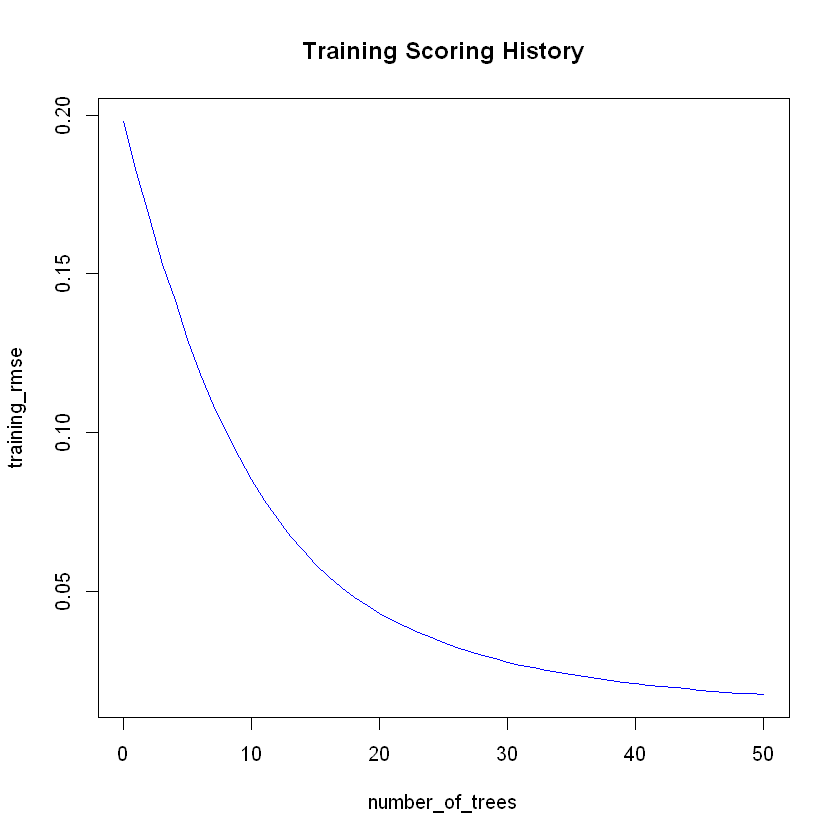

In [37]:
plot(fit)